In [10]:
#!pip install pandas==1.4.1 0 --user

In [11]:
#!pip install --upgrade ipykernel

C:\Users\niuser01\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.0.5
    Uninstalling traitlets-5.0.5:
      Successfully uninstalled traitlets-5.0.5
  Attempting uninstall: ipython
    Found existing installation: ipython 7.22.0
    Uninstalling ipython-7.22.0:
      Successfully uninstalled ipython-7.22.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.3.4
    Uninstalling ipykernel-5.3.4:
      Successfully uninstalled ipykernel-5.3.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


### 데이터 불러오기

In [1]:
import pandas as pd
import pickle

from tqdm import tqdm

In [2]:
DATA_PATH = "../data/pkl/"

In [3]:
data = pd.read_pickle(f'{DATA_PATH}merged_filtered_0630.pkl')
data.head(2)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,...,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부,city,filter_keyword,related_city
1,1500701.201604,19911212,부산일보,부산일보,[사람],지역>대전,지역>부산,지역>충남,NaN,NaN,...,"전남,최고경영자,凡一6동","金泉시의회,알래스카간,KBS홀,여성단체협의회장,동력자원부,모금추진위원회,학교,농림수...","사람,국제통상,주제,강연,전무,金殷湘,한국무역협회,11일,6시,강의실,부산대,경영,...","격려금,손목시계,국제통상,동구,원씩,慶南,金泉,머코스키,회의실,釜山日報社,근로자들,...",‘국제통상’ 주제 강연\n◇金殷湘 한국무역협회 전무=11일 오후 6시40분 부산대 ...,NaN,NaN,김해시,"{개최, 사업, 지역}",[[]]
2,1100611.201604,19911208,서울신문,NaN,농수산물 음성정보/74개 시 군으로 확대,IT_과학>인터넷_SNS,IT_과학>과학,IT_과학>모바일,NaN,NaN,...,"김해시,홍성군,서울,부산","농수산물유통공사,농수산","농수산물,음성,정보,74개,확대,농수산물유통공사,7일,농수산물,정보,음성,서비스,제...","농수산물,부산,김해시,전자식,부산등,전자식전화기,홍성군등,전화기,이용자,서울,농수산...",농수산물유통공사는 7일부터 농수산물정보음성서비스 제공지역을 서울 부산등 15개 시에...,http://www.seoul.co.kr/news/newsView.php?id=19...,NaN,김해시,{지역},[[김해시]]


In [4]:
data.columns

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부', 'city', 'filter_keyword',
       'related_city'],
      dtype='object')

In [5]:
data_PH = data[data['city'] == '포항시']


(62638, 22)

In [6]:
keyword_lst = data_PH['특성추출(가중치순 상위 50개)']

In [7]:
keyword_lst.shape

(62638,)

In [8]:
token_lst = []
for tokens in tqdm(enumerate(keyword_lst)):
    temp = str(tokens).split(",")
    temp_lst = []
    for item in temp:
        item = item.replace('"', "")
        item = item.replace("'", "")
        item = item.replace(" ", "")
        item = item.replace("(", "")
        item = item.replace(")", "")
        temp_lst.append(item)
    token_lst.append(temp_lst)

62638it [00:00, 63260.09it/s]


### 최적의 토픽 개수 찾기

In [11]:
# -*- coding: utf-8 -*-
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    limit = 100;
    start = 10;
    step = 10;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    return x, coherence_values


Duplicate key in file PosixPath('/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  NanumGothic')


In [12]:
processed_data = token_lst.copy()
# 정수 인코딩과 빈도수 생성
dictionary = corpora.Dictionary(processed_data)

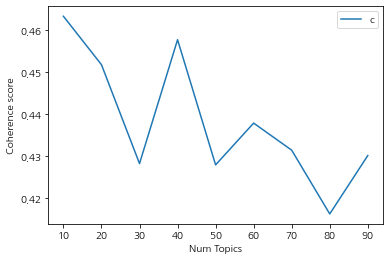

In [13]:
# 출현빈도가 적거나 자주 등장하는 단어는 제거
#dictionary.filter_extremes(no_below=5, no_above=0.02)
corpus = [dictionary.doc2bow(text) for text in processed_data]
# 최적의 토픽 수 찾기
x, coherence_values = find_optimal_number_of_topics(dictionary, corpus, processed_data)

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### tn 개의 토픽으로 LDA 돌리기 & LDA 결과 html로 시각화

In [20]:
from gensim import corpora
import gensim
import pyLDAvis.gensim_models
import time
from tqdm import tqdm

def LDA(tokenized_doc, tn):
    dictionary = corpora.Dictionary(tokenized_doc)
    corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

    NUM_TOPICS = tn #10개의 토픽, k=10
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=5)

    # sabe visualized LDA result
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
    pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, f'{DATA_PATH}4.html')


    return topics, ldamodel

In [30]:
# topic number & LDA data preparation
# tokenized_doc은 [[a,b,c],[e,d,f]]의 형식일 것!

tn = 14
topics, ldamodel = LDA(tokenized_doc, tn)

topics

C:\Users\niuser01\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


[(0, '0.057*"부산" + 0.034*"대구" + 0.033*"경기도" + 0.016*"장애인" + 0.016*"당사자"'),
 (1, '0.075*"유권자" + 0.035*"혐한" + 0.030*"일본" + 0.027*"도쿄" + 0.025*"유권자들"'),
 (2, '0.054*"동성애" + 0.041*"성소수자" + 0.026*"소수자" + 0.022*"동성애자" + 0.019*"유튜브"'),
 (3, '0.046*"한국" + 0.041*"외국인" + 0.036*"한국인" + 0.029*"노동자" + 0.026*"우리나라"'),
 (4, '0.060*"한국당" + 0.050*"민주당" + 0.034*"정치인" + 0.033*"청와대" + 0.029*"막말"'),
 (5, '0.060*"피해자" + 0.035*"서울" + 0.031*"여성들" + 0.026*"강남역" + 0.023*"성폭력"'),
 (6, '0.097*"일본" + 0.086*"한국" + 0.029*"매립장" + 0.028*"사람들" + 0.027*"폐기물"'),
 (7, '0.035*"청원" + 0.029*"일베" + 0.028*"그동안" + 0.027*"게시판" + 0.024*"청와대"'),
 (8, '0.040*"온라인" + 0.024*"악플" + 0.023*"누리꾼" + 0.021*"sns" + 0.021*"시민들"'),
 (9, '0.041*"학생들" + 0.034*"새누리당" + 0.030*"일본" + 0.029*"위안부" + 0.022*"아베"'),
 (10, '0.131*"미국" + 0.036*"영국" + 0.034*"독일" + 0.030*"프랑스" + 0.027*"한국"'),
 (11, '0.086*"주민들" + 0.037*"혐오시설" + 0.035*"처리장" + 0.029*"소각장" + 0.025*"위원회"'),
 (12, '0.151*"서울" + 0.036*"서울시" + 0.018*"한국" + 0.013*"부시" + 0.013*"개고기"'),
 (13, '0.035

In [32]:
ldamodel.save('20220624.lda')

### 기사별 토픽분포 확인

In [41]:
topics

[(0, '0.057*"부산" + 0.034*"대구" + 0.033*"경기도" + 0.016*"장애인" + 0.016*"당사자"'),
 (1, '0.075*"유권자" + 0.035*"혐한" + 0.030*"일본" + 0.027*"도쿄" + 0.025*"유권자들"'),
 (2, '0.054*"동성애" + 0.041*"성소수자" + 0.026*"소수자" + 0.022*"동성애자" + 0.019*"유튜브"'),
 (3, '0.046*"한국" + 0.041*"외국인" + 0.036*"한국인" + 0.029*"노동자" + 0.026*"우리나라"'),
 (4, '0.060*"한국당" + 0.050*"민주당" + 0.034*"정치인" + 0.033*"청와대" + 0.029*"막말"'),
 (5, '0.060*"피해자" + 0.035*"서울" + 0.031*"여성들" + 0.026*"강남역" + 0.023*"성폭력"'),
 (6, '0.097*"일본" + 0.086*"한국" + 0.029*"매립장" + 0.028*"사람들" + 0.027*"폐기물"'),
 (7, '0.035*"청원" + 0.029*"일베" + 0.028*"그동안" + 0.027*"게시판" + 0.024*"청와대"'),
 (8, '0.040*"온라인" + 0.024*"악플" + 0.023*"누리꾼" + 0.021*"sns" + 0.021*"시민들"'),
 (9, '0.041*"학생들" + 0.034*"새누리당" + 0.030*"일본" + 0.029*"위안부" + 0.022*"아베"'),
 (10, '0.131*"미국" + 0.036*"영국" + 0.034*"독일" + 0.030*"프랑스" + 0.027*"한국"'),
 (11, '0.086*"주민들" + 0.037*"혐오시설" + 0.035*"처리장" + 0.029*"소각장" + 0.025*"위원회"'),
 (12, '0.151*"서울" + 0.036*"서울시" + 0.018*"한국" + 0.013*"부시" + 0.013*"개고기"'),
 (13, '0.035

In [34]:
topic_list = []
for i, t in enumerate(ldamodel[corpus]):
    topic_list.append(t)
    
for t in range(len(topic_list)):
    topic_list[t] = sorted(dict(topic_list[t]).items(), key = lambda x:x[1], reverse=True)[0]

len(tokenized_doc) == len(topic_list)

True

In [35]:
topic = []
rat = []

for t in topic_list:
    topic.append(t[0])
    rat.append(t[1])
    
split_data['topicnum'] = topic
split_data['topic_rat'] = rat

In [44]:
split_data[split_data['topicnum'] == 6]['제목'][:50]

4                              [편집국에서] 바르다가 사랑한 노년 / 김은형
14                             생명 다루는 새 직장 똥 치울 시간도 부족하다
15                               일본 도쿄도 "혐오 발언 금지" 조례 시행
16                   [월간중앙] 강상중 도쿄대 명예교수가 말하는 ‘멀티튜드의 반란’
33                                        [창-박지훈] 약자의 게임
64                 “청소년ㆍ성인 소설 둘다 쓰는 비결? 날 항상 공백으로 남기는거죠”
66                       “지역경제 살릴 수만 있다면” 교정시설 유치 나선 태백시
67                 “청소년ㆍ성인 소설 둘다 쓰는 비결? 날 항상 공백으로 남기는거죠”
69                                  [특파원 칼럼] 시대착오적 혐오 경쟁
81                                         헤테로토피아의 섬에 서서
104                                        헤테로토피아의 섬에 서서
114                                           의주로 또는 통일로
145                                   [전우용의 우리시대]친일파의 시대
151                     “속국 근성의 식분 민족!” 일본연금기구 소장의 혐한 트윗
156                       "유튜브 하루 업로드 동영상, 다 보려면 18년 걸려"
199                  [영상+] “로힝야 난민 반대 시위대는 무엇이 두려운 걸까요?”
209                       "유튜브 하루 업로드 동영상, 다 보려면 18년 걸려"
224                김세경의 월드뮤직- 장

In [45]:
tname = []
hate = {0:'정치', 1: '정치', 2:'LGBT', 3: '이민자', 4: '정치', 5:'남성', 6: '외국내', 7:'정치',
        8: '플랫폼', 9:'일본', 10: '외국내', 11: '혐오시설', 12:'정치', 13: '정치'}
for t in topic:
    tname.append(hate[t])
    #tname.append([key for key, value in test.items() if value == t][0])
    
split_data['topic_name'] = tname

In [46]:
split_data.head()

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,...,본문,URL,분석제외 여부,year,month,day,특성추출top10,topicnum,topic_rat,topic_name
0,1101101.201903,20190331,한국일보,손영하,"페이스북 위기에 저커버그 입장 바꿔 ""온라인 규제 강화해야""",국제>국제일반,IT_과학>인터넷_SNS,NaN,NaN,NaN,...,세계적인 사회관계망서비스(SNS) 페이스북의 창업자이자 최고경영자(CEO)인 마크 ...,NaN,NaN,2019,3,31,"[페이스북, 저커버그, 온라인, 생중계, 도빌, 프랑스, 뉴질랜드, 미국, 샌드버그...",10,0.406234,외국내
1,1100611.201903,20190331,서울신문,이정수,“강간 갱뱅 칼빵 ” 래퍼 김효은 ‘머니 로드’ 가사 논란,문화>방송_연예,문화>생활,NaN,NaN,NaN,...,래퍼 김효은(26)의 신곡 ‘머니 로드’(Money Road)가 폭력적인 혐오 가사...,http://www.seoul.co.kr/news/newsView.php?id=20...,NaN,2019,3,31,"[김효은, 갱뱅, 칼빵, 온라인, 엠넷, 한국, 성폭력, 표현들, 가족들, 엠비션뮤직]",5,0.307490,남성
2,1100101.201903,20190331,경향신문,김희연 문화부장,"[아침을 열며]초연결 시대, 우리는 정말 ‘우리’가 될까",문화>영화,문화>출판,문화>미술_건축,사회>사회문제>빈곤,NaN,...,"나는 과연 초시대를 살고 있는가, 우리 사회는 초연결 사회가 될까.\n\n요즘 TV...",http://news.khan.co.kr/kh_news/khan_art_view.h...,NaN,2019,3,31,"[장애인, 미국, 서울, 도플갱어, 스마트한, 김희연, 한국, 5g, 아메리카, 사람들]",10,0.327709,외국내
3,1100101.201903,20190331,경향신문,오찬호 &lt;진격의 대학교&gt; 저자,[시선]인생을 건 부동산 투기,경제>부동산,문화>출판,사회>여성,사회>사회갈등>시위,NaN,...,그는 공공주택 건설을 반대하는 1인 시위 중이다. 이미 자신의 지역에 대규모 임대아...,http://news.khan.co.kr/kh_news/khan_art_view.h...,예외,2019,3,31,"[서울, 공공주택, 부동산, 불평등, 사람들, 임대아파트, 예정지, 쇼핑몰, 대학교...",10,0.494252,외국내
4,1101001.201903,20190331,한겨레,김은형,[편집국에서] 바르다가 사랑한 노년 / 김은형,문화>방송_연예,문화>영화,문화>전시_공연,NaN,NaN,...,김은형문화에디터\n\n 누벨바그의 어머니라고 일컬어지던 아녜스 바르다가 28일(현지...,http://www.hani.co.kr/arti/opinion/column/8881...,NaN,2019,3,31,"[바르다, 성형외과, 고다르, 누벨바그, 혜자, 제이아르, 아녜스, 사진가, 김은형...",6,0.767799,외국내


### 기사 수 세기

In [97]:
df = split_data.copy()
hates = ['정치','LGBT','이민자','남성','외국내','플랫폼','일본','혐오시설']
hate_cnt = {'정치':[],'LGBT':[],'이민자':[],'남성':[],'외국내':[],'플랫폼':[],'일본':[],'혐오시설':[]}


years = [i for i in range(2000, 2020)]
months = [i for i in range(1, 13)]
cnt = []
tcnt = []

for h in hates:
    for y in years:
        for m in months:
            condition = (df.topic_name == h) & (df.year == y) & (df.month == m)
            cnt.append(len(df[condition]))
        tcnt.extend(cnt)
        cnt = []
    hate_cnt[h].extend(tcnt)
    tcnt = []


In [98]:
year_hatecnt = pd.DataFrame(columns=['year','month','정치','LGBT','이민자','남성','외국내','플랫폼','일본','혐오시설'])

for h in hates:
    year_hatecnt[h] = hate_cnt[h]
    
year_hatecnt

,year,month,정치,LGBT,이민자,남성,외국내,플랫폼,일본,혐오시설
0,NaN,NaN,85,3,4,0,20,1,2,13
1,NaN,NaN,52,3,6,4,26,1,2,16
2,NaN,NaN,80,10,6,7,19,3,0,13
3,NaN,NaN,93,6,8,1,22,2,2,10
4,NaN,NaN,30,2,8,2,30,3,3,14
...,...,...,...,...,...,...,...,...,...,...
235,NaN,NaN,286,82,48,48,282,28,69,16
236,NaN,NaN,264,56,81,67,173,40,116,36
237,NaN,NaN,271,53,62,42,182,140,61,21
238,NaN,NaN,372,57,80,56,195,75,65,20


In [104]:
year_hatecnt['year'] = [k for k in range(2000, 2020) for i in range(12)]
year_hatecnt['month'] = [k for k in range(1, 13)]*len(years)


year_hatecnt

,year,month,정치,LGBT,이민자,남성,외국내,플랫폼,일본,혐오시설
0,2000,1,85,3,4,0,20,1,2,13
1,2000,2,52,3,6,4,26,1,2,16
2,2000,3,80,10,6,7,19,3,0,13
3,2000,4,93,6,8,1,22,2,2,10
4,2000,5,30,2,8,2,30,3,3,14
...,...,...,...,...,...,...,...,...,...,...
235,2019,8,286,82,48,48,282,28,69,16
236,2019,9,264,56,81,67,173,40,116,36
237,2019,10,271,53,62,42,182,140,61,21
238,2019,11,372,57,80,56,195,75,65,20


In [105]:
year_hatecnt.to_csv('year_hatecnt_beforecorona_0624.csv')

In [73]:
sum([6, 7, 4, 2, 5, 5, 6, 6, 4, 5, 6, 2])

58

In [266]:
from random import randrange

topic  = []
title = []
samples_aftercorona = pd.DataFrame(columns = ['topic', 'title'])

for h in ['LGBT']:
    dff = df[df['topic_name'] == h]
    dff = dff.sample(n = 3, random_state = randrange(1100000))

    topic.extend(dff['topic_name'].to_list())
    title.extend(dff['제목'].to_list())
    
samples_aftercorona['topic'] = topic
samples_aftercorona['title'] = title

samples_aftercorona

,topic,title
0,LGBT,“가까운 곳에 성소수자가 있음을 알리고 싶었어요”
1,LGBT,퀴어축제 “성소수자 혐오 반대에서 전체 소수자 혐오 반대로”
2,LGBT,"김조광수, 국내 첫 '동성 결혼' 공식 발표 혐오는 이제 그만!"


In [159]:
samples_aftercorona['title'][0]

"왕, 황제, 회장님 게임 출시 1년 '미녀'와 재미있으셨나요"